<a href="https://colab.research.google.com/github/BORDYR/PV-Generation-Forecasting/blob/main/SRPCNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch import nn
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler


import torch
from torch import nn
from tqdm.notebook import tqdm
import os
from torch.utils.tensorboard import SummaryWriter
from IPython import display

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

In [ ]:
!gdown --id 1GZxDATmFkkXhX2mjBq0q5OKoT5dT22Rc -O dataset.csv # https://drive.google.com/file/d/1y5skDqS7T40IMEQtskm2VSVTloKdmzij/view?usp=sharing https://drive.google.com/file/d/1aSoXnzJhs9XMQgmG-i-hscO7cte7-_Ol/view?usp=sharing my_path = "/content/drive/MyDrive/ProjDL/whole_set.nc"

Downloading...
From: https://drive.google.com/uc?id=1GZxDATmFkkXhX2mjBq0q5OKoT5dT22Rc
To: /content/dataset.csv
100% 497k/497k [00:00<00:00, 67.4MB/s]


In [ ]:
path = "/content/drive/MyDrive/DL project/dataset.csv"
df = pd.read_csv('/content/dataset.csv')
df = df.set_index(['time'])
df = df.iloc[:, :-1]

df.head()

,TempOut,WindSpeed,WindRun,SolarRad,SolarEnergy,HeatD-D,CoolD-D,OutHum
time,,,,,,,,
2014-06-10 02:30:00,15.7,0,0.0,0,0.0,0.056,0.0,89
2014-06-10 03:00:00,15.2,0,0.0,0,0.0,0.065,0.0,90
2014-06-10 03:30:00,14.9,0,0.0,0,0.0,0.072,0.0,90
2014-06-10 04:00:00,14.4,0,0.0,0,0.0,0.081,0.0,89
2014-06-10 04:30:00,14.2,0,0.0,0,0.0,0.087,0.0,90


Prepare Data

In [ ]:
def train_validate_test_split(df, train_percent=.6, val_percent=.2):
    m = len(df.index)
    train_end = int(train_percent * m)
    val_end = int(val_percent * m) + train_end
    
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, val, test

train, val, test = train_validate_test_split(df, train_percent=.8, val_percent=.1)
train.shape, val.shape, test.shape

((6244, 8), (780, 8), (781, 8))

In [ ]:
X_train = train
X_val = val
X_test = test

In [ ]:
class Dataset():
    def __init__(self, X_data_in, X_data_out):
        self.X_data_in = X_data_in
        self.X_data_out = X_data_out
        
    def __getitem__(self, index):
        return self.X_data_in[index], self.X_data_out[index]
    
    def __len__(self):
        return len(self.X_data_in)

    
train_dataset = Dataset(torch.from_numpy(X_train.to_numpy()).float(), 
                                  torch.from_numpy(X_train.to_numpy()).float())

val_dataset = Dataset(torch.from_numpy(X_val.to_numpy()).float(), 
                                  torch.from_numpy(X_val.to_numpy()).float())

test_dataset = Dataset(torch.from_numpy(X_test.to_numpy()).float(), 
                                  torch.from_numpy(X_test.to_numpy()).float())

Model

In [ ]:
class SRP(nn.Module):
    def __init__(self, in_channels, out_channels, hid_dim, n_layers, alpha):
        super().__init__()
        self.hid_dim = hid_dim

        self.feature_extraction = Feature_extraction(1, hid_dim)
        self.inf_supplement = Inf_supplement(hid_dim, 1, n_layers)
        self.reconstuction = Reconstuction(alpha, hid_dim, out_channels)
    
    def forward(self, x):
        bs, features = x.shape
        x = x.view(bs, 1, features)
        x = self.feature_extraction(x)
        x = self.inf_supplement(x)
        x = self.reconstuction(x)
        
        return x
        
        
class Feature_extraction(nn.Module):
    """
    input size: [p x df]
    output size: [p x m x df]
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        return self.conv(x)
        
class Inf_supplement(nn.Module):
    """
    input size: [p x m x df]
    output size: [p x m x df]
    """
    def __init__(self,in_channels, out_channels, n_layers=16):
        super().__init__()
        self.layers = nn.ModuleList(ResidulaBlock(in_channels, in_channels) for _ in range(n_layers-1))
        self.layers.append(ResidulaBlock(in_channels, out_channels))

    def forward(self, x):
        res = x.clone()
        for layer in self.layers:
            x = layer(x)
            
        return res + x
    
        
class Reconstuction(nn.Module):
    """
    input size: [p x m x df]
    intermediate size: [p x a x df]
    output size: [p x dc]
    """
    def __init__(self, alpha, hid_dim, out_channels, df=7):
        super().__init__()

        self.df = df

        self.conv1 = nn.Conv1d(hid_dim, alpha, kernel_size=3, padding=1)
        self.linear = nn.Linear(alpha*self.df, out_channels)

    def forward(self, x):
        bs,  df = x.shape[0], x.shape[2]
        x = self.conv1(x)
        alpha = x.shape[1]
        x = x.view(bs, alpha*df)
        x = self.linear(x)
        return x

       
 
    
class ResidulaBlock(nn.Module):
    """docstring for ResidulaBlock"""  
    def __init__(self, in_channels, out_channels, dropout=.2):
        super().__init__()
        self.up_branch = nn.Sequential(
            nn.Conv1d(in_channels, in_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels, in_channels, kernel_size=5, padding=2),
            #nn.BatchNorm1d(out_channels),
            #nn.Dropout(dropout),
            )
      

    def forward(self, x):
        res = x.clone()
        x = self.up_branch(x)
        x += res
        
        return x


Functions

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def plot(train_loss, val_loss, clear_output=True):
    if clear_output:
        display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
    ax.semilogy(train_loss, label="Train")
    ax.semilogy(val_loss, label="Val")
    ax.set_title('Train/Val loss')
    ax.set_xlabel('# batches processed')
    ax.set_ylabel('loss value')
    plt.legend()   
    
    plt.show()



def miss_model_run(model, dataloader, optimizer, loss_fun, phase='train', epoch=0, scheduller=None, writer=None):
    is_train = (phase == 'train')
    if is_train:
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0
    loss_per_epoch = []


    with torch.set_grad_enabled(is_train):        
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            epoch_i = epoch * len(dataloader) + i

            input, output = batch[0].to(device), batch[0].to(device)
          
            # random missimg index
            idx = torch.randint(0, input.shape[1], (1,)).item()
            # missing data
            input = input[:, torch.arange(input.size(1))!=idx] 
            # model
            input = model.forward(input)

            loss = loss_fun(output, input)

            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                if scheduller:
                    scheduller.step() 
                    
            loss_per_epoch.append(loss.item()) 

            #if i % 5 == 0:
            #    plot(loss_per_epoch, clear_output=True)
            
            if writer is not None and is_train:
                writer.add_scalar(f"loss/{phase}", loss.item(), epoch_i)
                writer.add_scalar(f"accuracy/{phase}", loss.item(), epoch_i)
                
            epoch_loss += loss.item()
        
        average_loss = epoch_loss / len(dataloader)

        
        if writer is not None:
            writer.add_scalar(f"loss_epoch/{phase}", average_loss, epoch)

        return average_loss



def test_run(best_model, dataloader, loss_fun):
    
    model  = SRP(in_channels = 1, out_channels = 8, hid_dim = 100, n_layers = 64, alpha = 20) 
    model.to(device) 
    model.eval()
    model.load_state_dict(best_model)
    
    epoch_loss = 0

    input_inv = torch.empty(8,8)
    mis_inv = torch.empty(8,8)

    with torch.no_grad():        
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

            input, output = batch[0].to(device), batch[0].to(device)
            mis_input=input
          
            # random missing index
            idx = torch.randint(0, input.shape[1], (1,)).item()
            
            
            mis_input[:,idx]=np.nan
            # missing data
            input = input[:, torch.arange(input.size(1))!=idx] 
            # model
            input = model.forward(input)
           

            input_inv = torch.vstack([input_inv, input.cpu()])
            mis_inv = torch.vstack([mis_inv, mis_input.cpu()])
            
            

            loss = loss_fun(output, input)
                       
            epoch_loss += loss.item()
        
        average_loss = epoch_loss / len(dataloader)

        return average_loss, input_inv, mis_inv



def train_missing_model(train_dataset, val_dataset, test_dataset, X_train, X_val, X_test, num_epochs=20, batch_size=32, normalize=False):
        
        
        if normalize:
          scaler = MinMaxScaler()

          X_train = scaler.fit_transform(X_train)
          X_val = scaler.transform(X_val)
          X_test = scaler.transform(X_test)

          train_dataset_ = Dataset(torch.from_numpy(X_train).float(), 
                                  torch.from_numpy(X_train).float())

          val_dataset_ = Dataset(torch.from_numpy(X_val).float(), 
                                  torch.from_numpy(X_val).float())
          
          test_dataset_ = Dataset(torch.from_numpy(X_test).float(), 
                                  torch.from_numpy(X_test).float())
        else:
          train_dataset_ = train_dataset
          val_dataset_ = val_dataset
          test_dataset_ = test_dataset



        
        train_dataloader = DataLoader(dataset=train_dataset_, batch_size=batch_size, shuffle=False) 
        val_dataloader = DataLoader(dataset=val_dataset_, batch_size=8)
        test_dataloader = DataLoader(dataset=test_dataset_, batch_size=8)

        model  = SRP(in_channels = 1, out_channels = 8, hid_dim = 100, n_layers = 64, alpha = 20) 
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6, eps=1e-6)
        loss_fun = torch.nn.MSELoss()
        #scheduller = torch.optim.lr_scheduler.MultiStepLR(optimizer1, [500, 1500], gamma=0.5)


        logs_base_dir = "/content/drive/My Drive/missing_model/writer/"
        os.makedirs(logs_base_dir, exist_ok=True)
        
        writer_name = 'logs'
        writer_path = os.path.join(logs_base_dir, writer_name)

        writer = SummaryWriter(writer_path)

        best_val_loss = float('+inf')

        path = 'missing_model.pth'
        
        loss_train = []
        loss_vall = []


        for epoch in range(0,num_epochs): 
          train_loss = miss_model_run(model, train_dataloader, optimizer, loss_fun, phase='train', epoch=epoch, scheduller=None, writer=None)
          val_loss = miss_model_run(model, val_dataloader, None, loss_fun, phase='val', epoch=epoch, scheduller=None, writer=None)

          loss_train.append(train_loss)
          loss_vall.append(val_loss)
          
          if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_missing_model = model.state_dict()
          
          print(f'Epoch: {epoch+1:02}')
          print(f'\tTrain Loss: {train_loss:.10f}')
          print(f'\t Val. Loss: {val_loss:.10f}') 
          
        torch.save(best_missing_model, path)
        plot(loss_train, loss_vall, clear_output=True)
         
        test_loss, input_inv,mis_inv = test_run(best_missing_model, test_dataloader, loss_fun)
        print(input_inv.shape)
        if normalize:
          input_inv =  scaler.inverse_transform(input_inv[8:,:])
          mis_inv =  scaler.inverse_transform(mis_inv[8:,:])
        #print(input_inv)
        print(f'\tTest Loss: {test_loss:.10f}')

        return input_inv,mis_inv  #mis_inv to save the data with gaps for plotting


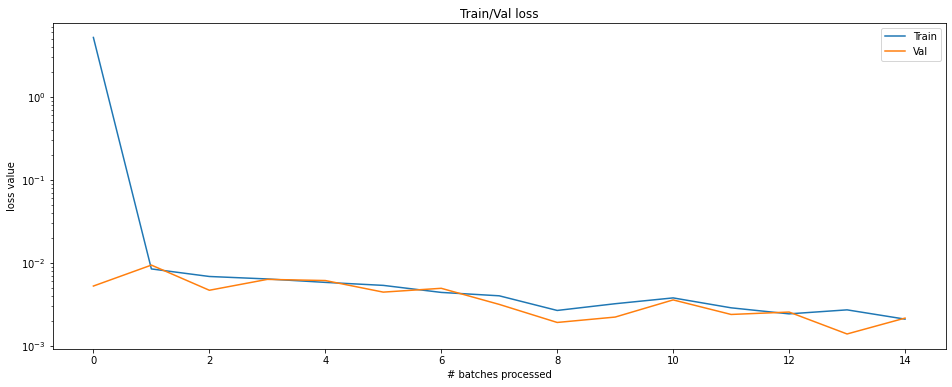


torch.Size([789, 8])
	Test Loss: 0.0054351585


In [ ]:
input_inv,mis_inv = train_missing_model(train_dataset, val_dataset, test_dataset, X_train, X_val, X_test, num_epochs=15, batch_size=64, normalize=True)


In [ ]:
X_test.head(20)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#@title Plotting
#fig = go.Figure()
df0 = X_test[:300]
df0=df0.reset_index()
df = pd.DataFrame(mis_inv)[:300]
df_pred = pd.DataFrame(input_inv)[:300]
df.reset_index(level=0, inplace=True)
fig = make_subplots(rows=8, cols=1,shared_xaxes=True,)

fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[0], mode='lines', name='pred',line=dict(color='#EF553B')), row=1, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[0], mode='lines',line=dict(color='royalblue'), name='true'), row=1, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['TempOut'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=1, col=1)

fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[1], mode='lines', name='pred_WindSpeed',line=dict(color='#EF553B'), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[1], mode='lines',line=dict(color='royalblue'),  name='WindSpeed',showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['WindSpeed'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=2, col=1)


fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[2], mode='lines', name='pred_WindRun',line=dict(color='#EF553B'),showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[2], mode='lines',line=dict(color='royalblue'),  name='WindRun',showlegend=False), row=3, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['WindRun'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=3, col=1)


fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[3], mode='lines', name='pred_SolarRad',line=dict(color='#EF553B'),showlegend=False), row=4, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['SolarRad'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=4, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[3], mode='lines',line=dict(color='royalblue'), name='SolarRad',showlegend=False), row=4, col=1)


fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[4], mode='lines', name='pred_SolarEnergy',line=dict(color='#EF553B'),showlegend=False), row=5, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['SolarEnergy'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=5, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[4], mode='lines',line=dict(color='royalblue'), name='SolarEnergy',showlegend=False), row=5, col=1)


fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[5], mode='lines', name='pred_HeatD-D',line=dict(color='#EF553B'),showlegend=False), row=6, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['HeatD-D'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=6, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[5], mode='lines',line=dict(color='royalblue'), name='HeatD-D',showlegend=False), row=6, col=1)


fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[6], mode='lines', name='pred_CoolD-D',line=dict(color='#EF553B'),showlegend=False), row=7, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['CoolD-D'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=7, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[6], mode='lines',line=dict(color='royalblue'), name='CoolD-D',showlegend=False), row=7, col=1)


fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred[7], mode='lines', name='pred_OutHum',line=dict(color='#EF553B'),showlegend=False), row=8, col=1)
fig.add_trace(go.Scatter(x=df0.index, y=df0['OutHum'], mode='lines',line=dict(color='royalblue', dash='dot'),showlegend=False), row=8, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df[7], mode='lines',line=dict(color='royalblue'), name='OutHum',showlegend=False), row=8, col=1)




fig.update_layout(width=600, height=1400, template='plotly_white',showlegend=True, legend=dict(x=0.83, y=1,bordercolor="Black",borderwidth=2))

fig.update_xaxes( row=1, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text='TempOut [deg C]', row=1, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.update_xaxes( row=2, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text="WindSpeed [m/s]", row=2, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.update_xaxes( row=3, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text='WindRun [km of wind]', row=3, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.update_xaxes( row=4, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text='SolarRad [W/m2]', row=4, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.update_xaxes( row=5, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text='SolarEnergy [Ly]', row=5, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.update_xaxes( row=6, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text='HeatD-D [deg-day]', row=6, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.update_xaxes( row=7, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text='CoolD-D [deg-day]', row=7, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.update_xaxes(title='Number of observations', row=8, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True,ticks='inside',nticks=10)
fig.update_yaxes(title_text='OutHum [%]', row=8, col=1,showline=True, linewidth=1.5, linecolor='black', mirror=True)

fig.show()

#with open('/content/test_pred2.html', 'a') as f:

#        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn', default_height = 1200, default_width = 900))
       
#fig.write_html('/content/test_pred2.html')


In [ ]:
%load_ext tensorboard 
%tensorboard --logdir '/content/drive/My Drive/missing_model/writer/logs'